### 文本预处理
分词、去除停用词、按照一定的格式组装数据、并将处理好的数据保存到磁盘，后续进行复用

In [1]:
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
import matplotlib.pyplot as plt

### 从文件中读取词数据，并将词数据生成集合返回

In [2]:
def make_word_set(words_file_path):
    '''
    从文件中读取词数据，并将词数据生成集合返回
    :words_file_path 保存词数据的文件路径
    :return 词集合
    '''
    words_set = set()
    with open(words_file_path, 'r') as fp:
        for line in fp.readlines():
            word = line.strip().decode("utf-8")
            # 去掉重复的词
            if len(word)>0 and word not in words_set:
                words_set.add(word)
    return words_set

### 切词，并去除停用词，将切好的词分文件保存到磁盘，后续进行复用

In [3]:
def word_cut(folder_path, stopwords_set=set()):
    '''
    切词，并去除停用词，将切好的词分文件保存到磁盘，后续进行复用
    :folder_path 语料库路径
    :stopwords_set 停用词集合，默认为空集
    '''
    import jieba
    import jieba.posseg as posseg
    
    # 需要去除的词性
    stop_flags = ('x', 'uj', 'ul', 'm', 'p', 'c', 't', 'l', 'd', 'ad')
    # 允许保留的词性
    allow_flags = ('v', 'n', 'a', 'ag', 'g', 'vg', 'ng', 'nr', 'ns', 'nt', 'nz', 'i')

    # 分词-遍历文件夹，获取各个类别子目录的目录名称列表
    folder_list = os.listdir(folder_path)

    # 遍历类别子目录的目录名称
    for folder in folder_list:
        # 拼装类别子目录的路径
        new_folder_path = os.path.join(folder_path, folder)
        # 获取类别子目录下文本文件的名称列表
        files = os.listdir(new_folder_path)
        # 读取文本文件
        for file in files:
            # 拼装文本文件的路径，并读取文件
            with open(os.path.join(new_folder_path, file), 'r') as fp:
                # 获取文件内容
                raw = fp.read()
            #### 结巴分词 ####
            # 开启并行分词模式，参数为并行进程数，不支持windows
            jieba.enable_parallel(1)
            # 精确模式分词，返回的结构是一个可以迭代的genertor
            word_cut = posseg.cut(raw)
            # 将分好的词生成对应目录存入磁盘，方便复用
            # 如果目录不存在，创建目录
            if not os.path.exists('/home/beanyon/Desktop/naive_bayes_classifier/segs/' + folder + '/'):
                os.makedirs('/home/beanyon/Desktop/naive_bayes_classifier/segs/' + folder + '/')
            # 把切好的词写入文件
            with open('/home/beanyon/Desktop/naive_bayes_classifier/segs/' + folder + '/' + file, 'w') as f:
                for word, flag in word_cut:
                    # 使用停用词性过滤词
                    #if flag not in stop_flags and not word.isdigit() and 1<len(word)<5 and word not in stop_words_set:
                    # 使用允许词性过滤词
                    if flag in allow_flags and not word.isdigit() and 1<len(word)<5 and word not in stopwords_set:
                        # 把符合要求的词写入文件，并追加一个分隔符
                        f.write((word + '|||').encode('utf-8'))
            # 关闭并行分词模式
            jieba.disable_parallel()

### 从切好的词目录中读取样本（feature和label）

In [4]:
def get_samples(dir_path):
    '''
    从切好的词目录中读取样本（feature和label）
    :dir_path 词目录
    '''
    # 词特征集合
    feature_list = []
    # 标签集合
    label_list = []
    # 获取所有的类别子目录名称
    folder_list = os.listdir(dir_path)
    # 读取已经分好的词-遍历文件夹
    for folder in folder_list:
        # 组装类别子目录路径
        new_folder_path = os.path.join(dir_path, folder)
        # 获取类别子目录下的全部文件名
        files = os.listdir(new_folder_path)
        # 读取文件，获取feature和label
        for file in files:
            with open(os.path.join(new_folder_path, file), 'r') as fp:
               raw = fp.read()
            word_list = raw.split('|||') 
            # 将特征和标签分别加入集合
            feature_list.append(word_list) #训练集list
            label_list.append(folder.decode('utf-8')) #类别
    return feature_list, label_list

### 将样本集合分割为训练集和测试集，并分离特征和标签

In [5]:
def split_samples(feature_label_list, test_size=0.2):
    '''
    将样本集合分割为训练集和测试集，并分离特征和标签
    :feature_label_list 样本集合，特征和标签一一对应
    :test_size 测试集所占的比例
    :return 训练特征集合、训练标签集合、测试特征集合、测试标签集合
    '''
    import random
    
    # 打乱数据的顺序
    random.shuffle(feature_label_list)
    # 计算训练集和测试集的分割点
    index = int(len(feature_label_list)*test_size)+1
    # 划分训练集和测试集
    train_list = feature_label_list[index:]
    test_list = feature_label_list[:index]
    # 分割feature和label
    train_data_list, train_class_list = zip(*train_list)
    test_data_list, test_class_list = zip(*test_list)
    
    # 统计训练集的词频放入all_words_dict
    all_words_dict = {}
    for word_list in train_data_list:
        for word in word_list:
            if all_words_dict.has_key(word):
                all_words_dict[word] += 1
            else:
                all_words_dict[word] = 1

    # key函数利用词频进行降序排序
    all_words_tuple_list = sorted(all_words_dict.items(), key=lambda f:f[1], reverse=True) # 内建函数sorted参数需为list
    all_words_list = list(zip(*all_words_tuple_list)[0])
    return all_words_list, train_data_list, train_class_list, test_data_list, test_class_list

### 将列表数据写入文件

In [6]:
def write_list_to_file(file_path, list, separator):
    '''
    将列表数据写入文件
    :file_path 要写入的路径
    :list 需要写入的的列表
    :separator 每项间的分隔符
    '''
    with open(file_path, 'w') as file:
        file.write(separator.join(list))

### 选取特征词

In [7]:
def select_feature_words(all_words_list, deleteN, feature_dimen):
    '''
    选取特征词
    :all_words_list 词袋全集
    :deleteN 词偏移量（抛弃前N个词）
    :feature_dimen 特征维度
    :return 选取的特征词列表
    '''
    feature_words = []
    n = 1
    for t in range(deleteN, len(all_words_list), 1):
        if n > feature_dimen: # feature_words的维度1000
            break
            
        feature_words.append(all_words_list[t])
        n += 1
    return feature_words

### 提取文档特征（向量化文档）

In [8]:
def text_features(train_data_list, test_data_list, feature_words):
    '''
    提取文档特征（向量化文档）
    :train_data_list 训练集全部feature
    :test_data_list 测试集全部feature
    :feature_words 从词袋中选取的特征词列表
    :return 提取到的训练特征列表，提取到的测试特征列表
    '''
    def text_feature(text, feature_words):
        '''
        根据特征词列表生成每个文档的特征词向量
        :text 分词后的文档
        :feature_words 特征词空间
        :return 特征词向量
        '''
        text_words = set(text)
        features = [1 if word in text_words else 0 for word in feature_words]
        return features
    # 生成训练集的词向量
    train_feature_list = [text_feature(text, feature_words) for text in train_data_list]
    # 生成测试集的词向量
    test_feature_list = [text_feature(text, feature_words) for text in test_data_list]
    return train_feature_list, test_feature_list

### 分类，并返回准确率

In [9]:
def text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag='MultinomialNB'):
    '''
    分类，并返回准确率
    :train_feature_list 训练集特征
    :test_feature_list 测试集特征
    :train_class_list 训练集标签
    :test_class_list 测试集标签
    :return 分类器精度
    '''
    classifier = None
    if flag == 'BernoulliNB':
        # 伯努力朴素贝叶斯
        classifier = BernoulliNB().fit(train_feature_list, train_class_list)
    elif flag == 'GaussianNB':
        # 高斯朴素贝叶斯
        classifier = GaussianNB().fit(train_feature_list, train_class_list)
    else:
        # 多项式朴素贝叶斯
        classifier = MultinomialNB().fit(train_feature_list, train_class_list)
    test_accuracy = classifier.score(test_feature_list, test_class_list)
    return test_accuracy

### 寻找最好的词空间偏移量(即抛弃最前面的多少个词后精度最高)（仅在需要的时候独立执行）

In [10]:
def find_best_word_offset(all_words_list, train_data_list, test_data_list, train_class_list, test_class_list, words_offset):
    '''
    寻找最好的词空间偏移量(即抛弃最前面的多少个词后精度最高)
    :all_words_list 词袋全集
    :train_data_list 训练集词特征列表
    :test_data_list 测试集词特征列表
    :train_class_list 训练集标签列表
    :test_class_list 测试集标签列表
    :words_offset 词偏移量
    :return 分类精度集合
    '''
    # 步间隔为20，循环到偏移量为1000为止
    deleteNs = range(0, 1000, 20)
    # 存储50次偏移的对应预测精度
    test_accuracy_list = []
    # 以不同的偏移量进行训练和预测
    for deleteN in deleteNs:
        # 选取特征词
        feature_words = select_feature_words(all_words_list, deleteN, words_offset)
        # 提取文档特征（向量化文档）
        train_feature_list, test_feature_list = text_features(train_data_list, test_data_list, feature_words)
        # 预测并获取精度
        test_accuracy = text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag='MultinomialNB')
        # 将精度添加到列表中
        test_accuracy_list.append(test_accuracy)
    
    # 结果评价，绘制折线图
    plt.plot(deleteNs, test_accuracy_list)
    plt.title('Relationship of deleteNs and test_accuracy')
    plt.xlabel('deleteNs')
    plt.ylabel('test_accuracy')
    plt.show()
    return test_accuracy_list

### 寻找最好的特征词空间大小(即从词袋中选取多少个特征词)（仅在需要的时候独立执行）

In [11]:
def find_best_bag_size(all_words_list, train_data_list, test_data_list, train_class_list, test_class_list):
    '''
    寻找最好的词特征空间尺寸(即特征词空间一共包含多少个词)
    :all_words_list 词袋全集
    :train_data_list 训练集词特征列表
    :test_data_list 测试集词特征列表
    :train_class_list 训练集标签列表
    :test_class_list 测试集标签列表
    :return 分类精度集合
    '''
    # 步间隔为1000，循环到特征词空间大小为5000为止
    bow_sizes = range(1000, 5000, 1000)
    # 存储不同词特征空间尺寸下的精度
    test_accuracy_list = []
    # 以不同的特征词空间尺寸进行训练和预测
    for bow_size in bow_sizes:
       feature_words = select_feature_words(all_words_list, 0, bow_size)
       train_feature_list, test_feature_list = text_features(train_data_list, test_data_list, feature_words)
       test_accuracy = text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag='MultinomialNB')
       test_accuracy_list.append(test_accuracy)
        
    # 结果评价，绘制折线图
    plt.plot(bow_sizes, test_accuracy_list)
    plt.title('Relationship of bow_sizes and test_accuracy')
    plt.xlabel('bow_sizes')
    plt.ylabel('test_accuracy')
    plt.show()
    return test_accuracy_list

### 使用训练集和测试集进行训练并测试

In [12]:
def classify(all_words_list, train_data_list, test_data_list, train_class_list, test_class_list):
    '''
    使用训练集和测试集进行训练并测试
    :all_words_list 词袋全集
    :train_data_list 训练集词特征列表
    :test_data_list 测试集词特征列表
    :train_class_list 训练集标签列表
    :test_class_list 测试集标签列表
    :return 分类精度集合
    '''
    feature_words = select_feature_words(all_words_list, 0, 5000)
    train_feature_list, test_feature_list = text_features(train_data_list, test_data_list, feature_words)
    test_accuracy = text_classifier(train_feature_list, test_feature_list, train_class_list, test_class_list, flag='MultinomialNB')
    return test_accuracy

### 切词，去除停用词后保存到磁盘，方便复用（仅在需要分词的时候执行）

In [13]:
%%time
# 读取停用词，生成停用词集合
stopwords_file_path = '/home/beanyon/Desktop/naive_bayes_classifier/stopwords_cn.txt'
stopwords_set = make_word_set(stopwords_file_path)
# 切词、去除停用词后保存，方便复用
folder_path = '/home/beanyon/Desktop/naive_bayes_classifier/Database/SogouC/Sample.20000'
word_cut(folder_path, stopwords_set)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.166 seconds.
Prefix dict has been built succesfully.


CPU times: user 11min 5s, sys: 16min 46s, total: 27min 51s
Wall time: 2h 37min 8s


### 进行一次完整的训练和测试流程

In [ ]:
%%time
# 从切好的词目录中获取特征和样本
seg_dir = '/home/beanyon/Desktop/naive_bayes_classifier/segs/'
feature_list, label_list = get_samples(seg_dir)
# 合并样本和对应标签
feature_label_list = zip(feature_list, label_list)
# 将样本集合分割为训练集和测试集，并分离特征和标签
all_words_list, train_data_list, train_class_list, test_data_list, test_class_list = split_samples(
    feature_label_list, 0.4)
# 将切分好的训练集词袋全集写入文件
words_bag_path = '/home/beanyon/Desktop/naive_bayes_classifier/all_words_list.txt'
write_list_to_file(words_bag_path, all_words_list, '\n')

# 使用训练集和测试集进行训练并测试
test_accuracy = classify(all_words_list, train_data_list, test_data_list, train_class_list, test_class_list)
print test_accuracy

### 寻找最好的词空间偏移量(即抛弃最前面的多少个词后精度最高)（仅在需要的时候独立执行）

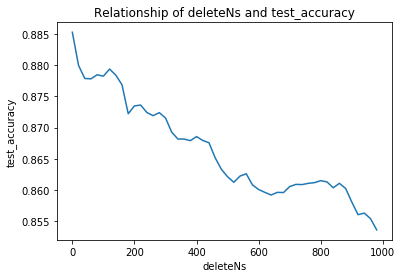

[0.8852747502270663, 0.8799670753860127, 0.8778667120799274, 0.8778099455040872, 0.8784627611262489, 0.8782356948228883, 0.8793710263396912, 0.8784059945504087, 0.8768449137148048, 0.8722184377838329, 0.8734673024523161, 0.8736092188919165, 0.8724171207992734, 0.871906221616712, 0.8723887375113533, 0.8715372388737511, 0.8692665758401453, 0.8681596276112625, 0.8681596276112625, 0.8679041780199819, 0.8685569936421436, 0.8679325613079019, 0.8675635785649409, 0.8651509990917348, 0.8633060853769301, 0.862113987284287, 0.8612341053587648, 0.8622275204359673, 0.8625965031789282, 0.8608083560399636, 0.8600703905540418, 0.8596162579473207, 0.8591905086285195, 0.8596162579473207, 0.8595878746594006, 0.860552906448683, 0.8608935059037239, 0.8608651226158038, 0.8610638056312443, 0.8611773387829246, 0.8614895549500454, 0.8612908719346049, 0.8603542234332425, 0.8610638056312443, 0.8602406902815622, 0.8580551771117166, 0.8560399636693915, 0.8562954132606722, 0.8554155313351499, 0.8535990009082652]
CP

In [17]:
%%time
# 寻找最好的词空间偏移量(即抛弃最前面的多少个词后精度最高)
test_accuracy_list = find_best_word_offset(all_words_list,
                                           train_data_list,
                                           test_data_list, 
                                           train_class_list,
                                           test_class_list,
                                           2000)
print test_accuracy_list

### 寻找最好的特征词空间大小(即从词袋中选取多少个特征词)（仅在需要的时候独立执行）

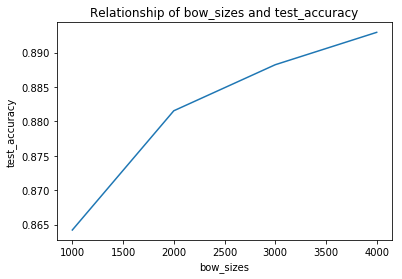

[0.8642143505903724, 0.8815565395095368, 0.8882549954586739, 0.892966621253406]
CPU times: user 1min 25s, sys: 7.19 s, total: 1min 33s
Wall time: 1min 23s


In [18]:
%%time
# 寻找最好的特征词空间大小(即从词袋中选取多少个特征词)
test_accuracy_list = find_best_bag_size(all_words_list,
                                        train_data_list,
                                        test_data_list, 
                                        train_class_list,
                                        test_class_list)
print test_accuracy_list